# **Open Data Examples** | Analyzing Property Ownership
This notebook will walk you through the following:
* Fetch Cuyahoga County GIS and Cuyahoga Fiscal Officer's property data for Cleveland
* Use `cledatatoolkit` library to detect property owners that are corporate (businesses, companies, non-profits, i.e. not individuals)

To run this notebook, you will need to install the following packages using `pip`:
* Cleveland Urban AI's `cledatatoolkit`
* `requests`

In [1]:
import cledatatoolkit
import requests
import geopandas as gpd
import io

In [35]:
# Download the Cuyahoga County GIS combined parcel dataset for Cleveland only

# Simple function to save a requested URL to file

# This is a URL to the Cleveland Combined parcels dataset geoJSON download from the Cuyahoga County Open Data site.
url = "https://opendata.arcgis.com/api/v3/datasets/a84be47945564300a2119f6b9a411d59_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
# Download the geoJSON and store in-memory
response = requests.get(url)
parcels_geojson = io.BytesIO(response.content)

# Load the parcels into a geodataframe which has full table plus the shape of the parcels in space.
# This could take a couple minutes!
parcels_gdf = gpd.read_file(parcels_geojson).to_crs(epsg=3734)

In [37]:
# Download Cleveland neighborhood boundaries

# Like above, this URL downloads the city neighborhoods from City of Cleveland Open Data.
url = "https://opendata.arcgis.com/api/v3/datasets/b2a2da54401a41e78dd71563f01f5273_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
# Download the geoJSON and store in-memory
response = requests.get(url)
nbhd_geojson = io.BytesIO(response.content)

# Load the parcels into a geodataframe which has full table plus the shape of the parcels in space.
nbhd_gdf = gpd.read_file(nbhd_geojson).to_crs(epsg=3734)

## Spatial Operations
The Cuyahoga County property dataset does not come with a column for City neighborhood, or ward.

In order to break down the property data by those regions, we need to do a "spatial join" that will add the information to parcel dataset based on a *spatial relationship*.

In this case, it's a simple relationship: *Is the center of the parcel inside the ward/neighborhood/district/etc?*

In [20]:
from cledatatoolkit.spatial import largest_overlap

In [39]:
joined = largest_overlap(target_gdf=parcels_gdf,
                         target_key = 'parcelpin',
                         join_gdf=nbhd_gdf,
                         transfer_field= 'SPANM',
                         new_name= 'Neighborhood')

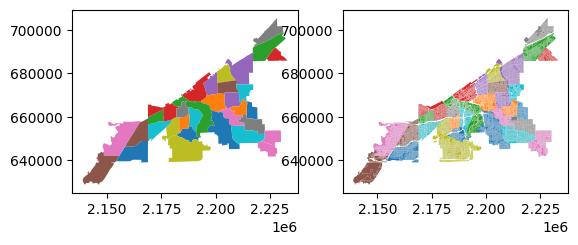

In [49]:
# Plot neighborhoods and parcels data using their respective neighborhood name fields.
# We can see the join worked as expected. T
import matplotlib.pyplot as plt

fig,axes = plt.subplots(ncols=2)

nbhd_gdf.plot('SPANM', ax=axes[0])
joined.plot("Neighborhood", ax = axes[1])
axes[0].set_title = 'Neighborhood Layer'
axes[1].set_title = 'Parcels Joined'

In [ ]:
# If you do not have cle-data-toolkit installed, you can do spatial joins navtively in geopandas.

# This block is an alternative to using largest_overlap.
# SKIP THIS SECTION IF YOU DID THE ABOVE 
# It uses the central points of each parcel to see which neighborhood it falls into.

# Generate a central point geometry in its own column
parcels_gdf["centroid"] = parcels_gdf.centroid
parcels_gdf = parcels_gdf.set_geometry("centroid")
joined = gpd.sjoin(parcels_gdf, nbhd_gdf, how="left", predicate="within")
joined.plot("Neighborhood")
# Set geometry back to the polygon
parcels_gdf = parcels_gdf.set_geometry("geometry")

## Analyze Property Ownership
Let's explore the nature of ownership by neighborhood.

An increasingly relevant need in local government is understanding patterns and trends in corporate ownership of property.
Over the last 20 years, especially in the wake of the subprime mortgage crisis between 2007-2010, there has been an influx of bad faith out-of-state investor owners
that have purchased a substantial amount of land in Cleveland. These are referred to informally as *LLC owners*, though their corporate structure can be many different things.

There are also good-faith corporate owners in Cleveland. Market-rate and affordable housing developers, education, non-profit and other instutions regularly incorporate and own land.

The `cledatatoolkit` has a library of regular expressions tailored to parse through County property data's `deeded_owner` field to flag patterns in more complicated ways.

